In [ ]:
# !pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu117

Training Examples:                                       sequence  count
75220  [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]      8
48955     [1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1]      8
44966                    [1, 0, 0, 0, 1, 1, 0]      3
13568                          [1, 0, 0, 0, 0]      1
92727        [1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0]      6
BitCountingRNN(
  (rnn): RNN(1, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
[4.142863  4.142922  4.1428223 ... 4.1428285 4.142867  4.14282  ]
Epoch 1, Validation MAE (RNN): 2.265660524368286
Epoch 1, Random Baseline MAE: 2.5557375
[5.1205444 3.1851947 3.1851943 ... 5.1205444 3.1851943 5.1205444]
Epoch 2, Validation MAE (RNN): 2.1486332416534424
Epoch 2, Random Baseline MAE: 2.5490625
[4.9512157 2.8317952 2.831795  ... 4.9512157 2.831795  4.9512157]
Epoch 3, Validation MAE (RNN): 2.127392292022705
Epoch 3, Random Baseline MAE: 2.5449625
[5.0455003 3.0486436 3.0486436 ... 5.0455003 3.0

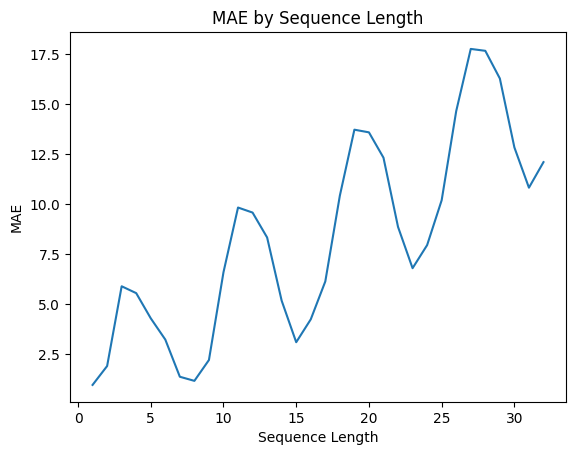

In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

class BitCountingRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, dropout=0.2):
        super(BitCountingRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)  # Output is the count of 1's

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take the last time-step's output
        return out

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.metrics import mean_absolute_error

# Generate dataset
def generate_bit_sequence_dataset(num_sequences=100000, min_len=1, max_len=16):
    sequences = []
    counts = []
    for _ in range(num_sequences):
        length = np.random.randint(min_len, max_len + 1)
        sequence = np.random.randint(0, 2, length).tolist()
        count = sum(sequence)
        sequences.append(sequence)
        counts.append(count)
    return sequences, counts

# Convert sequences to tensors and create DataLoaders
def sequences_to_tensor(sequences, counts):
    max_len = max(len(seq) for seq in sequences)
    padded_seqs = [seq + [0] * (max_len - len(seq)) for seq in sequences]
    x_tensor = torch.tensor(padded_seqs, dtype=torch.float32).unsqueeze(-1)
    y_tensor = torch.tensor(counts, dtype=torch.float32)
    return x_tensor, y_tensor

# Create sequences and labels
sequences, counts = generate_bit_sequence_dataset()

# Split the dataset
data = pd.DataFrame({"sequence": sequences, "count": counts})
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
validate_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

print("Training Examples:", train_data.head())


# Model instantiation
model = BitCountingRNN()
print(model)


x_train, y_train = sequences_to_tensor(train_data["sequence"].tolist(), train_data["count"].tolist())
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=32, shuffle=True)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        outputs = model(x_batch).squeeze()
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation MAE
    model.eval()
    with torch.no_grad():
        val_preds = model(x_train).squeeze().numpy()
        val_mae = mean_absolute_error(y_train.numpy(), val_preds)
    print((val_preds))
    random_preds = []
    for seq in train_data["sequence"].tolist():  # Use training data for baseline
        random_preds.append(np.random.randint(0, len(seq) + 1))
    random_mae = mean_absolute_error(train_data["count"].tolist(), random_preds)

    print(f"Epoch {epoch+1}, Validation MAE (RNN): {val_mae}")
    print(f"Epoch {epoch+1}, Random Baseline MAE: {random_mae}")



# Generate out-of-distribution sequences and evaluate MAE for each length
mae_by_length = []
for seq_len in range(1, 33):
    seqs, counts = generate_bit_sequence_dataset(num_sequences=1000, min_len=seq_len, max_len=seq_len)
    x_tensor, y_tensor = sequences_to_tensor(seqs, counts)
    with torch.no_grad():
        preds = model(x_tensor).squeeze().numpy()
        mae = mean_absolute_error(y_tensor.numpy(), preds)
    mae_by_length.append(mae)

# Plot MAE by sequence length
plt.plot(range(1, 33), mae_by_length)
plt.xlabel('Sequence Length')
plt.ylabel('MAE')
plt.title('MAE by Sequence Length')
plt.show()


- **A gradual increase in MAE with sequence length suggests that the model is overfitting to the training data and struggling with longer, unseen sequences.**
